In [1]:
import matplotlib.pyplot as plt
from ekarus.e2e.single_stage_ao_class import SingleStageAO
from ekarus.e2e.devices.pyramid_wfs import PyramidWFS

import xupy as xp
from ekarus.e2e.utils.image_utils import reshape_on_mask
from numpy.ma import masked_array

from arte.utils.radial_profile import computeRadialProfile



[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [3]:
tn = 'master_single_stage'

ssao = SingleStageAO(tn)
ssao.initialize_turbulence('ekarus_15cm')
KL, m2c = ssao.define_KL_modes(ssao.dm, zern_modes=5)
Rec, IM = ssao.compute_reconstructor(ssao.sc, KL, ssao.pyr.lambdaInM, ampsInM=50e-9, save_prefix='')
ssao.sc.load_reconstructor(IM,m2c)

lambdaRef = ssao.pyr.lambdaInM

Initializing devices ...
Modulating 3 [lambda/D] with 20 modulation steps
Fried parameter is: 10.0 [cm] (seeing = 1.01")
/home/matte/git/ekarus/ekarus/simulations/atmo/ekarus_15cm/atmospheric_phase_layers.fits


RMS of the reconstructed phase is: 618.05 [nm], sum of KL coefficients is: 3292.04 [nm]


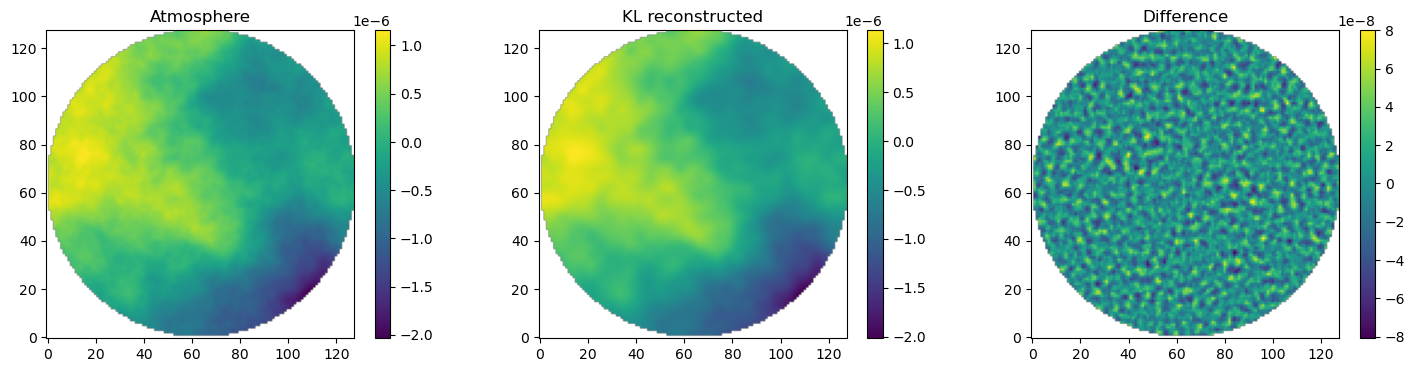

In [4]:
atmo_phase = ssao.get_phasescreen_at_time(0)
atmo_phase -= xp.mean(atmo_phase[~ssao.cmask])

phi = atmo_phase[~ssao.cmask]
modes = xp.linalg.pinv(KL.T) @ phi

rec_phi = KL.T @ modes
rec_phase = reshape_on_mask(rec_phi, ssao.cmask)

delta_phase = atmo_phase - rec_phase

sh = 1.0

plt.figure(figsize=(18,4))
plt.subplot(1,3,1)
plt.imshow(masked_array(xp.asnumpy(atmo_phase),xp.asnumpy(ssao.cmask)), origin='lower')
plt.colorbar(shrink=sh)
plt.title('Atmosphere')
plt.subplot(1,3,2)
plt.imshow(masked_array(xp.asnumpy(rec_phase),xp.asnumpy(ssao.cmask)), origin='lower')
plt.colorbar(shrink=sh)
plt.title('KL reconstructed')
plt.subplot(1,3,3)
plt.imshow(masked_array(xp.asnumpy(delta_phase),xp.asnumpy(ssao.cmask)), origin='lower')
plt.colorbar(shrink=sh)
plt.title('Difference')

print(f'RMS of the reconstructed phase is: {xp.sqrt(xp.sum(rec_phi**2)/len(rec_phi))*1e+9:1.2f} [nm], sum of KL coefficients is: {xp.sum(abs(modes))*1e+9:1.2f} [nm]')

In [5]:
pupilDiameterInM = 8
lambdaInM = 750e-9
oversampling = 8
lambdaOverD = lambdaInM/pupilDiameterInM


apex_angle = 100*(2*xp.pi)*lambdaOverD
wfs = PyramidWFS(apex_angle, oversampling, sensorLambda=lambdaInM)
wfs.set_modulation_angle(2.0)

Modulating 2 [lambda/D] with 12 modulation steps


In [7]:
    
def get_mtf(wfs, phase, mask):

    phase_in_rad = reshape_on_mask(phase, mask)*2*xp.pi/wfs.lambdaInM
    input_field = (1-mask) * xp.exp(1j*phase_in_rad,dtype=wfs.cdtype)

    L = max(input_field.shape)
    padded_field = xp.pad(input_field, int((wfs.oversampling-1)/2*L), mode='constant', constant_values=0.0)
    tiltX,tiltY = wfs._get_XY_tilt_planes(padded_field.shape)

    alpha_pix = wfs.modulationAngleInLambdaOverD*wfs.oversampling*(2*xp.pi)
    phi_vec = (2*xp.pi)*xp.arange(wfs._modNsteps)/wfs._modNsteps

    intensity = xp.zeros(padded_field.shape,dtype=wfs.dtype)
    phase_delay = wfs.pyramid_phase_delay(padded_field.shape) / lambdaOverD

    for phi in phi_vec:
        tilt = tiltX * xp.cos(phi) + tiltY * xp.sin(phi)
        tilted_input = padded_field * xp.exp(1j*tilt*alpha_pix, dtype=wfs.cdtype)
        field_on_focal_plane = xp.fft.fftshift(xp.fft.fft2(tilted_input))
        ef_focal_plane_delayed = field_on_focal_plane * xp.exp(1j*phase_delay, dtype=wfs.cdtype)
        intensity += xp.abs(ef_focal_plane_delayed)**2

    mtf = xp.fft.fftshift(xp.fft.fft2(intensity))
    mtf = (abs(mtf))

    # padded_mask = xp.abs(padded_field) != 0

    plt.figure()
    plt.imshow(xp.asnumpy(xp.log(mtf)),origin='lower',cmap='twilight')
    # plt.imshow(masked_array(xp.asnumpy(xp.log(mtf)),xp.asnumpy(~padded_mask)),origin='lower',cmap='twilight')
    plt.colorbar()

    return mtf

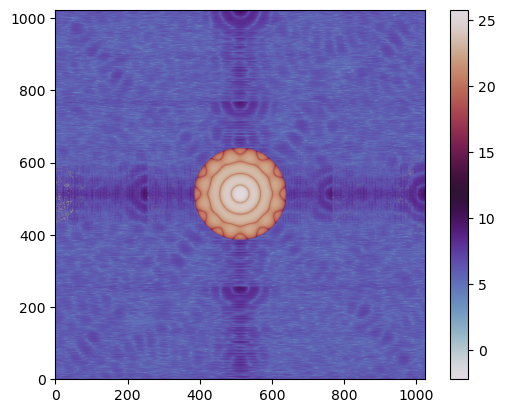

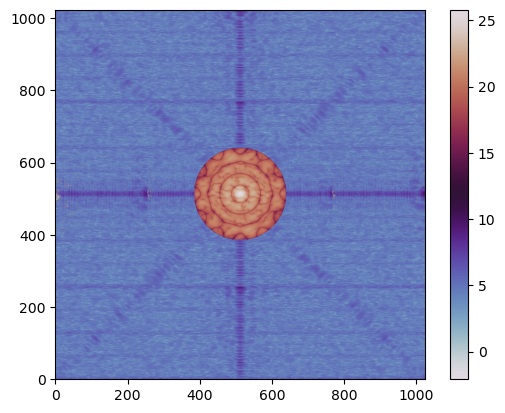

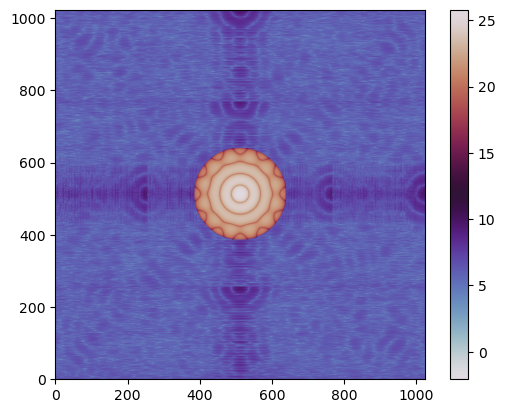

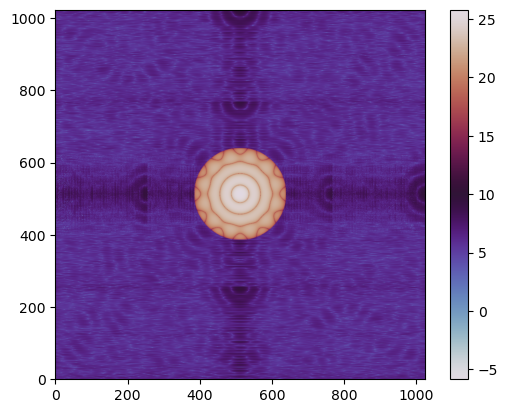

In [8]:
mtf = get_mtf(wfs, phi/10, ssao.cmask)
rmtf = get_mtf(wfs, rec_phi, ssao.cmask)
dmtf = get_mtf(wfs, phi-rec_phi, ssao.cmask)
mtf0 = get_mtf(wfs, phi*0, ssao.cmask)

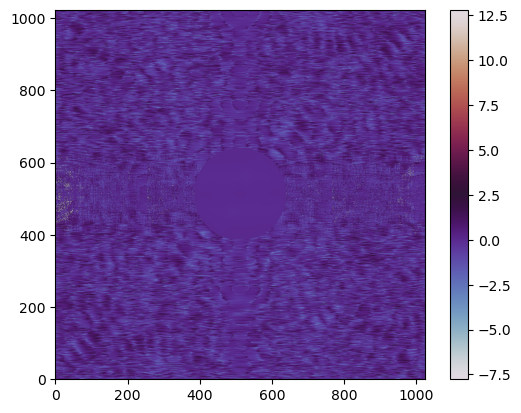

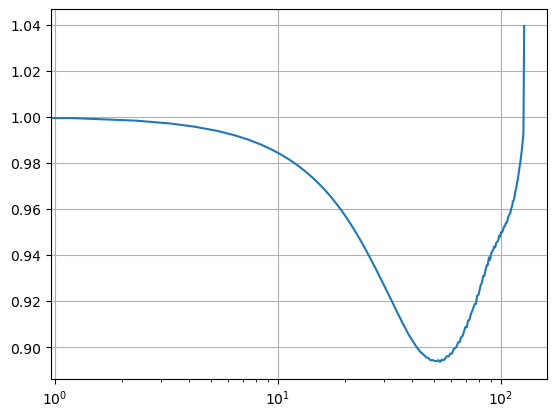

In [9]:

ratio = mtf/mtf0
plt.figure()
plt.imshow(xp.asnumpy(xp.log(ratio)),origin='lower',cmap='twilight')
plt.colorbar()

Npix = max(xp.shape(ratio))
rad_profile, distance = computeRadialProfile(xp.asnumpy(ratio), centerInPxX=Npix//2, centerInPxY=Npix//2)

Nmax = 128
plt.figure()
plt.plot(xp.asnumpy(distance[:Nmax]),xp.asnumpy(rad_profile[:Nmax]))
plt.grid()
plt.xscale('log')
# plt.yscale('log')

In [ ]:
# phi_fit = delta_phase[~ssao.cmask]
# phi_fit *= 2*xp.pi/lambdaRef

# off_slopes = ssao._get_slopes(ssao.sc, KL, lambdaRef, amp, phase_offset=phi_fit)
# ref_slopes = ssao._get_slopes(ssao.sc, KL, lambdaRef, amp)

In [ ]:
# ref_IM = ref_slopes.T
# off_IM = off_slopes.T

# plt.figure()
# plt.plot(xp.asnumpy(xp.std(ref_IM,axis=0)),label='reference')
# plt.plot(xp.asnumpy(xp.std(off_IM,axis=0)),label='offset')
# plt.legend()
# plt.grid()


In [ ]:
# off_Rec = xp.linalg.pinv(off_IM)
# ref_Rec = xp.linalg.pinv(ref_IM)

In [ ]:
# Nmodes= xp.shape(KL)[0]
# electric_field_amp = 1-ssao.cmask
# lambdaOverD = lambdaRef/ssao.pupilSizeInM

# opt_gains = xp.zeros(Nmodes)
# ref_gains = xp.zeros(Nmodes)

# for i in range(Nmodes):
#     print(f'\rMode {i:1.0f}/{Nmodes:1.0f}',end='\r',flush=True)
#     mode_phase = reshape_on_mask(KL[i,:]*amp + phi_fit, ssao.cmask)
#     input_field = electric_field_amp * xp.exp(1j*mode_phase)
#     slope = ssao.sc.compute_slopes(input_field, lambdaOverD, None)
#     rec_mode = off_Rec @ slope
#     opt_gains[i] = rec_mode[i]/amp
#     rec_mode = ref_Rec @ slope
#     ref_gains[i] = rec_mode[i]/amp


In [ ]:
# plt.figure()
# plt.plot(xp.asnumpy(ref_gains),'-.',label='0-point calibration')
# plt.xlim([0,200])
# plt.grid()

In [ ]:
# plt.figure()
# plt.plot(xp.asnumpy(ref_gains),'-.',label='0-point calibration')
# plt.plot(xp.asnumpy(opt_gains),'-.',label='offset calibration')
# plt.legend()
# plt.xscale('log')
# plt.grid()